# Get/Update State

When running LangGraph agents, you can easily get or update the state of the agent at any point in time. This allows for several things. Firstly, it allows you to inspect the state and take actions accordingly. Second, it allows you to modify the state - this can be useful for changing or correcting potential actions.

**Note:** this requires passing in a checkpointer.

## Setup

First we need to install the packages required

In [1]:
!pip install --quiet -U langchain langchain_openai tavily-python


[notice] A new release of pip is available: 23.3.1 -> 23.3.2
[notice] To update, run: pip install --upgrade pip


Next, we need to set API keys for OpenAI (the LLM we will use) and Tavily (the search tool we will use)

In [2]:
import os
import getpass

os.environ["OPENAI_API_KEY"] = getpass.getpass("OpenAI API Key:")
os.environ["TAVILY_API_KEY"] = getpass.getpass("Tavily API Key:")

OpenAI API Key: ········
Tavily API Key: ········


Optionally, we can set API key for [LangSmith tracing](https://smith.langchain.com/), which will give us best-in-class observability.

In [ ]:
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_API_KEY"] = getpass.getpass("LangSmith API Key:")

## Set up the tools

We will first define the tools we want to use.
For this simple example, we will use a built-in search tool via Tavily.
However, it is really easy to create your own tools - see documentation [here](https://python.langchain.com/docs/modules/agents/tools/custom_tools) on how to do that.


In [1]:
from langchain_community.tools.tavily_search import TavilySearchResults

tools = [TavilySearchResults(max_results=1)]

We can now wrap these tools in a simple ToolNode.
This is a prebuilt node that extracts tool calls from the most recent AIMessage, executes them, and returns a ToolMessage with the results.


In [2]:
from langgraph.prebuilt import ToolNode

tool_node = ToolNode(tools)

## Set up the model

Now we need to load the chat model we want to use.
Importantly, this should satisfy two criteria:

1. It should work with messages. We will represent all agent state in the form of messages, so it needs to be able to work well with them.
2. It should work with OpenAI function calling. This means it should either be an OpenAI model or a model that exposes a similar interface.

Note: these model requirements are not requirements for using LangGraph - they are just requirements for this one example.

In [3]:
from langchain_openai import ChatOpenAI

model = ChatOpenAI(temperature=0)


After we've done this, we should make sure the model knows that it has these tools available to call.
We can do this using the `.bind_tools()` method, common to many of LangChain's chat models.


In [4]:
model = model.bind_tools(tools)

## Define the nodes

We now need to define a few different nodes in our graph.
In `langgraph`, a node can be either a function or a [runnable](https://python.langchain.com/docs/expression_language/).
There are two main nodes we need for this:

1. The agent: responsible for deciding what (if any) actions to take.
2. A function to invoke tools: if the agent decides to take an action, this node will then execute that action.

We will also need to define some edges.
Some of these edges may be conditional.
The reason they are conditional is that based on the output of a node, one of several paths may be taken.
The path that is taken is not known until that node is run (the LLM decides).

1. Conditional Edge: after the agent is called, we should either:
   a. If the agent said to take an action, then the function to invoke tools should be called
   b. If the agent said that it was finished, then it should finish
2. Normal Edge: after the tools are invoked, it should always go back to the agent to decide what to do next

Let's define the nodes, as well as a function to decide how what conditional edge to take.

In [5]:
# Define the function that determines whether to continue or not
def should_continue(messages):
    last_message = messages[-1]
    # If there is no function call, then we finish
    if not last_message.tool_calls:
        return "end"
    # Otherwise if there is, we continue
    else:
        return "continue"

## Define the graph

We can now put it all together and define the graph!

In [6]:
from langgraph.graph import MessageGraph, END

# Define a new graph
workflow = MessageGraph()

# Define the two nodes we will cycle between
workflow.add_node("agent", model)
workflow.add_node("action", tool_node)

# Set the entrypoint as `agent`
# This means that this node is the first one called
workflow.set_entry_point("agent")

# We now add a conditional edge
workflow.add_conditional_edges(
    # First, we define the start node. We use `agent`.
    # This means these are the edges taken after the `agent` node is called.
    "agent",
    # Next, we pass in the function that will determine which node is called next.
    should_continue,
    # Finally we pass in a mapping.
    # The keys are strings, and the values are other nodes.
    # END is a special node marking that the graph should finish.
    # What will happen is we will call `should_continue`, and then the output of that
    # will be matched against the keys in this mapping.
    # Based on which one it matches, that node will then be called.
    {
        # If `tools`, then we call the tool node.
        "continue": "action",
        # Otherwise we finish.
        "end": END,
    },
)

# We now add a normal edge from `tools` to `agent`.
# This means that after `tools` is called, `agent` node is called next.
workflow.add_edge("action", "agent")

**Persistence**

To add in persistence, we pass in a checkpoint when compiling the graph

In [7]:
from langgraph.checkpoint.sqlite import SqliteSaver

memory = SqliteSaver.from_conn_string(":memory:")

In [8]:
# Finally, we compile it!
# This compiles it into a LangChain Runnable,
# meaning you can use it as you would any other runnable
app = workflow.compile(checkpointer=memory)

## Preview the graph

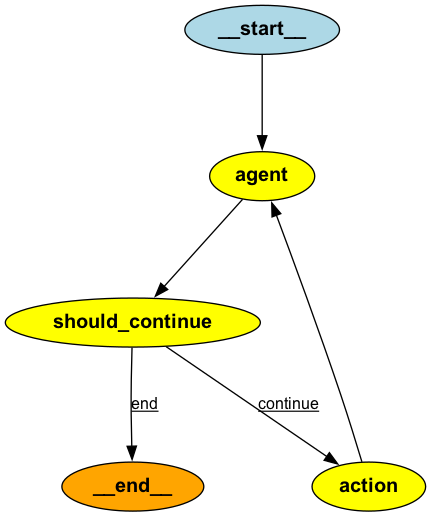

In [9]:
from IPython.display import Image

Image(app.get_graph().draw_png())

## Interacting with the Agent

We can now interact with the agent. Between interactions you can get and update state.


In [10]:
from langchain_core.messages import HumanMessage

thread = {"configurable": {"thread_id": '3'}}
for event in app.stream("hi! I'm bob", thread):
    for v in event.values():
        print(v)

content='Hello Bob! How can I assist you today?' response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 86, 'total_tokens': 97}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'stop', 'logprobs': None} id='run-f36a6fff-7732-43ed-b2a1-4d6cde4c073d-0'


See LangSmith example run here https://smith.langchain.com/public/01c1d61c-6943-4db1-8afe-5366f083caf3/r

Here you can see the "agent" node ran, and then "should_continue" returned "end" so the graph stopped execution there.

Let's now get the current state

In [11]:
app.get_state(thread).values

[HumanMessage(content="hi! I'm bob", id='8b86e367-6571-4333-86db-ed089288fd4f'),
 AIMessage(content='Hello Bob! How can I assist you today?', response_metadata={'token_usage': {'completion_tokens': 11, 'prompt_tokens': 86, 'total_tokens': 97}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_c2295e73ad', 'finish_reason': 'stop', 'logprobs': None}, id='run-f36a6fff-7732-43ed-b2a1-4d6cde4c073d-0')]

The current state is the two messages we've seen above, 1. the HumanMessage we sent in, 2. the AIMessage we got back from the model.

In [12]:
app.get_state(thread).next

()

The graph got to the end without interruptions, so the list of next nodes is empty.

### Let's get it to execute a tool

In [13]:
for event in app.stream("what is the weather in sf currently", thread):
    for v in event.values():
        print(v)

content='' additional_kwargs={'tool_calls': [{'id': 'call_S1BSXnmEYRcs1Aed2obUsi4J', 'function': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 111, 'total_tokens': 133}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-3d0caf20-5c92-4dd4-bd55-551d29fe6eb4-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'current weather in San Francisco'}, 'id': 'call_S1BSXnmEYRcs1Aed2obUsi4J'}]
[ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1712938752, \'localtime\': \'2024-04-12 9:19\'}, \'current\': {\'last_updated_epoc

See LangSmith example run here https://smith.langchain.com/public/c33c04c5-f1f2-4977-9d7d-c48f28be7be2/r

We can see it planned the tool execution (ie the "agent" node), then "should_continue" edge returned "continue" so we proceeded to "action" node, which executed the tool, and then "agent" node emitted the final response, which made "should_continue" edge return "end". Let's see how we can have more control over this.

### Pause before tools

If you notice below, we now will add `interrupt_before=["action"]` - this means that before any actions are taken we pause. This is a great moment to allow the user to correct and update the state! This is very useful when you want to have a human-in-the-loop to validate (and potentially change) the action to take. 

In [14]:
app_w_interrupt = workflow.compile(checkpointer=memory, interrupt_before=["action"])

In [15]:
thread = {"configurable": {"thread_id": '4'}}
for event in app_w_interrupt.stream("what is the weather in sf currently", thread):
    for v in event.values():
        print(v)

content='' additional_kwargs={'tool_calls': [{'id': 'call_ZzRMxOoMFp5ydcbpAQptdHbL', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]} response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 88, 'total_tokens': 109}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'tool_calls', 'logprobs': None} id='run-1b01c302-8e24-43fe-9324-572d67bc529e-0' tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco'}, 'id': 'call_ZzRMxOoMFp5ydcbpAQptdHbL'}]


See LangSmith example run here https://smith.langchain.com/public/22402055-a50e-4d82-8b3e-733c9d752bc5/r
This time it executed the "agent" node same as before, and you can see in the LangSmith trace that "should_continue" returned "continue", but it paused execution per our setting above.

This is the function call the model produced

In [16]:
current_values = app_w_interrupt.get_state(thread)
current_values.next

('action',)

Because we asked to interrupt the graph before getting to the action node, the next node to execute, if we were to resume, would be the "action" node.

In [17]:
current_values.values[-1].tool_calls

[{'name': 'tavily_search_results_json',
  'args': {'query': 'weather in San Francisco'},
  'id': 'call_ZzRMxOoMFp5ydcbpAQptdHbL'}]

Let's update the search string before proceeding

In [18]:
current_values.values[-1].tool_calls[0]['args']['query'] = "weather in San Francisco today"

In [19]:
app_w_interrupt.update_state(thread, current_values.values)

{'configurable': {'thread_id': '4',
  'thread_ts': '2024-04-12T16:19:26.369199+00:00'}}

This actually produces a LangSmith run too! See it here https://smith.langchain.com/public/9d86718b-333e-4175-bec0-9a64cdd01dc3/r

This is a shorter run that allows you to inspect the edges that reacted to the state update, you can see "should_continue" returned "continue" as before, given this is still a function call.

The current state now reflects our updated search query!

In [20]:
app_w_interrupt.get_state(thread).values

[HumanMessage(content='what is the weather in sf currently', id='27b8dc9e-0e43-4c20-bb9f-53ee27c791f1'),
 AIMessage(content='', additional_kwargs={'tool_calls': [{'id': 'call_ZzRMxOoMFp5ydcbpAQptdHbL', 'function': {'arguments': '{"query":"weather in San Francisco"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 21, 'prompt_tokens': 88, 'total_tokens': 109}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'tool_calls', 'logprobs': None}, id='run-1b01c302-8e24-43fe-9324-572d67bc529e-0', tool_calls=[{'name': 'tavily_search_results_json', 'args': {'query': 'weather in San Francisco today'}, 'id': 'call_ZzRMxOoMFp5ydcbpAQptdHbL'}])]

In [21]:
app_w_interrupt.get_state(thread).next

('action',)

If we start the agent again it will pick up from the state we updated.

In [22]:
for event in app_w_interrupt.stream(None, thread):
    for v in event.values():
        print(v)

[ToolMessage(content='[{"url": "https://www.weatherapi.com/", "content": "{\'location\': {\'name\': \'San Francisco\', \'region\': \'California\', \'country\': \'United States of America\', \'lat\': 37.78, \'lon\': -122.42, \'tz_id\': \'America/Los_Angeles\', \'localtime_epoch\': 1712938752, \'localtime\': \'2024-04-12 9:19\'}, \'current\': {\'last_updated_epoch\': 1712938500, \'last_updated\': \'2024-04-12 09:15\', \'temp_c\': 12.2, \'temp_f\': 54.0, \'is_day\': 1, \'condition\': {\'text\': \'Partly cloudy\', \'icon\': \'//cdn.weatherapi.com/weather/64x64/day/116.png\', \'code\': 1003}, \'wind_mph\': 11.9, \'wind_kph\': 19.1, \'wind_degree\': 260, \'wind_dir\': \'W\', \'pressure_mb\': 1008.0, \'pressure_in\': 29.76, \'precip_mm\': 0.0, \'precip_in\': 0.0, \'humidity\': 77, \'cloud\': 75, \'feelslike_c\': 10.5, \'feelslike_f\': 51.0, \'vis_km\': 16.0, \'vis_miles\': 9.0, \'uv\': 4.0, \'gust_mph\': 12.8, \'gust_kph\': 20.5}}"}]', name='tavily_search_results_json', id='578c3d3b-f905-412e

See this run in LangSmith here https://smith.langchain.com/public/8262c0f9-0701-4d73-95f6-2a32f6d3f96a/r

This continues where we left off, with "action" node, followed by "agent" node, which terminates the execution.

## Checking history

Let's browse the history of this thread, from newest to oldest.

In [25]:
for state in app_w_interrupt.get_state_history(thread):
    print(state)
    print('--')
    if len(state.values) == 2:
        to_replay = state

StateSnapshot(values=[HumanMessage(content='what is the weather in sf currently', id='06076c4e-40fe-4f44-978a-612fed60849c'), AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"weather in San Francisco today"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'function_call', 'logprobs': None}, id='run-966f6180-3c8f-42d5-af89-906650c46ab5-0'), FunctionMessage(content='[{\'url\': \'https://weather.com/weather/hourbyhour/l/USCA0987:1:US\', \'content\': "recents\\nSpecialty Forecasts\\nHourly Weather-San Francisco, CA\\nBeach Hazard Statement\\nSaturday, November 25\\n5 pm\\nClear\\n6 pm\\nClear\\n7 pm\\nClear\\n8 pm\\nMostly Clear\\n9 pm\\nPartly Cloudy\\n10 pm\\nPartly Cloudy\\n11 pm\\nPartly Cloudy\\nSunday, November 26\\n12 am\\nPartly Cloudy\\n1 am\\nMostly Cloudy\\n2 am\\n

We can go back to any of these states and restart the agent from there!

In [26]:
to_replay.values

[HumanMessage(content='what is the weather in sf currently', id='06076c4e-40fe-4f44-978a-612fed60849c'),
 AIMessage(content='', additional_kwargs={'function_call': {'arguments': '{"query":"current weather in San Francisco"}', 'name': 'tavily_search_results_json'}}, response_metadata={'token_usage': {'completion_tokens': 22, 'prompt_tokens': 88, 'total_tokens': 110}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'function_call', 'logprobs': None}, id='run-966f6180-3c8f-42d5-af89-906650c46ab5-0')]

In [27]:
to_replay.next

('action',)

### Replay a past state

To replay from this place we just need to pass its config back to the agent.

In [28]:
for event in app_w_interrupt.stream(None, to_replay.config):
    for v in event.values():
        print(v)

content="[{'url': 'https://www.accuweather.com/en/us/san-francisco/94103/current-weather/347629', 'content': 'Get the latest weather conditions and forecast for San Francisco, CA. See the temperature, humidity, wind, pressure, cloud cover, and alerts for the current hour and the next few days.'}]" name='tavily_search_results_json' id='82d6c2ac-260c-4d5d-9541-21ac4fab8916'
content='You can check the current weather conditions and forecast for San Francisco, CA on [AccuWeather](https://www.accuweather.com/en/us/san-francisco/94103/current-weather/347629). It will provide you with information on temperature, humidity, wind, pressure, cloud cover, and alerts for the current hour and the next few days.' response_metadata={'token_usage': {'completion_tokens': 75, 'prompt_tokens': 194, 'total_tokens': 269}, 'model_name': 'gpt-3.5-turbo', 'system_fingerprint': 'fp_b28b39ffa8', 'finish_reason': 'stop', 'logprobs': None} id='run-b4ab153a-266f-44c2-ad37-5fd2a869003a-0'


See this run in LangSmith here https://smith.langchain.com/public/f26e9e1d-16df-48ae-98f7-c823d6942bf7/r

This is similar to the previous run, this time with the original search query, instead of our modified one. 

### Branch off a past state

In [29]:
branch_config = app_w_interrupt.update_state(to_replay.config, AIMessage(content='All done here!', id=to_replay.values[-1].id))

In [30]:
branch_state = app_w_interrupt.get_state(branch_config)

In [31]:
branch_state.values

[HumanMessage(content='what is the weather in sf currently', id='06076c4e-40fe-4f44-978a-612fed60849c'),
 AIMessage(content='All done here!', id='run-966f6180-3c8f-42d5-af89-906650c46ab5-0')]

In [32]:
branch_state.next

()

You can see the snapshot was updated and now correctly reflects that there is no next step.

You can see this in LangSmith update run here https://smith.langchain.com/public/65104717-6eda-4a0f-93c1-4755c6f929ed/r

This shows the "should_continue" edge now reacting to this replaced message, and now changing the outcome to "end" which finishes the computation.